This notebook was created by :
**ANOUAR** **ZAHRAN** /
**SAAD** **BELAOUAD**/
**ADNAN** **ELMOUTTAKI**

### Spark session

In [1]:
#Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import *

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("FlightAnalysis").getOrCreate()
#Upload data
df_2009 = spark.read.csv("2009.csv", header=True, inferSchema=True)

23/11/27 16:42:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


##  Pre-Preccesing   

In [3]:
df_2009.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: do

In [4]:
# Check for missing values in df_2009
missing_2009 = df_2009.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_2009.columns])

In [5]:
missing_2009.show()

23/11/27 16:42:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|      0| 

In [9]:
# Drop rows with missing values in specific columns
columns_to_drop_na = ["FL_DATE", "OP_CARRIER", "ORIGIN", "DEST"]
df = df_2009.dropna(subset=columns_to_drop_na)

# Fill missing values in numerical columns with the mean
numerical_columns = ["DEP_TIME", "DEP_DELAY", "TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "ARR_TIME", "ARR_DELAY", "CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME", "AIR_TIME", "DISTANCE", "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"]
for column in numerical_columns:
    df = df_2009.withColumn(column, col(column).cast("double"))
    mean_value = df_2009.select(mean(column)).collect()[0][0]
    df = df_2009.fillna(mean_value, subset=[column])

# Drop unnecessary columns
columns_to_drop = ["CANCELLATION_CODE", "Unnamed: 27"]
df = df_2009.drop(*columns_to_drop)

# Show the cleaned dataset
df.show()


+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2009-01-01|        XE|             1204|   DCA| EWR|        1100|  1058.0|     -2.0|    18

### Initialize Pangerank

In [10]:
# Create Vertices DataFrame
vertices = df.selectExpr("ORIGIN as id").distinct().union(df.selectExpr("DEST as id").distinct())

# Create Edges DataFrame
edges = df.selectExpr("ORIGIN as src", "DEST as dst", "1 as weight")

# Initialize PageRank values
vertices = vertices.withColumn("pagerank", lit(1.0))

# Begin iterations
number_of_iterations = 10  # for example
for iteration in range(number_of_iterations):
    # Calculate contributions by joining vertices and edges on the source id
    contributions = edges.join(vertices, edges.src == vertices.id) \
                         .selectExpr("dst", "weight * pagerank as contribution")

    # Sum contributions by destination id and update PageRank values
    sums = contributions.groupBy("dst").sum("contribution").withColumnRenamed("sum(contribution)", "sum_contributions")
    vertices = vertices.join(sums, vertices.id == sums.dst, "left_outer") \
                       .selectExpr("id", "0.15 + 0.85 * coalesce(sum_contributions, 0) as pagerank")

# Final PageRank values are now stored in the vertices DataFrame
vertices.show()



23/11/27 16:47:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 16:47:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 16:47:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 16:47:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 16:47:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 16:47:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 16:47:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 16:47:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 16:48:01 WARN RowBasedKeyValueBatch: Calling spill() on

+---+--------------------+
| id|            pagerank|
+---+--------------------+
|BGM| 2.17650497941544E50|
|BGM| 2.17650497941544E50|
|DLG|2.426314211886089...|
|DLG|2.426314211886089...|
|PSE|2.187343674343410...|
|PSE|2.187343674343410...|
|MSY|1.294118812363754E52|
|MSY|1.294118812363754E52|
|GEG|3.827381239015259E51|
|GEG|3.827381239015259E51|
|BUR|8.557133885779645E51|
|BUR|8.557133885779645E51|
|SNA|1.708250542979014...|
|SNA|1.708250542979014...|
|GRB|2.909089576856056E51|
|GRB|2.909089576856056E51|
|GTF|7.234583410535763E50|
|GTF|7.234583410535763E50|
|IDA|1.082789307310683...|
|IDA|1.082789307310683...|
+---+--------------------+
only showing top 20 rows



**Vertices:** Each airport is uniquely identified, often by its airport code as (JFK, LAX).

**Edges:** each edge has a direction, going from an origin airport to a destination airport. so the edges are directed from the src (source) airport to the dst (destination) airport.each edge can have a uniform weight, often set to 1, indicating a connection exists between two airports.

In [ ]:
# Create Vertices DataFrame

# Vertices represent the airports
vertices = df.selectExpr("ORIGIN as id").distinct().union(df.selectExpr("DEST as id").distinct())

# Create Edges DataFrame
# Edges represent the flight routes, with a simple weight of 1 for each route
edges = df.selectExpr("ORIGIN as src", "DEST as dst").distinct()
edges = edges.groupBy("src", "dst").count().withColumnRenamed("count", "weight")

# Initialize PageRank values for each vertex
vertices = vertices.withColumn("pagerank", lit(1.0))

# Define the number of iterations and the tolerance for convergence checking
number_of_iterations = 10
tolerance = 0.01

# Begin PageRank iterations
for iteration in range(number_of_iterations):
    # Broadcast the vertices DataFrame to optimize joins
    # Rename the 'pagerank' column for clarity before broadcasting
    broadcast_vertices = broadcast(vertices.selectExpr("id as vertex_id", "pagerank as current_pagerank"))

    # Calculate contributions by joining vertices and edges on the source id
    contributions = edges.join(broadcast_vertices, edges.src == broadcast_vertices.vertex_id) \
                         .selectExpr("dst", "weight * current_pagerank as contribution")

    # Sum contributions by destination id and update PageRank values
    sums = contributions.groupBy("dst").agg(sum_("contribution").alias("sum_contributions"))
    new_vertices = vertices.join(sums, vertices.id == sums.dst, "left_outer") \
                           .selectExpr("id", "0.15 + 0.85 * coalesce(sum_contributions, 0) as pagerank")

    # Before the next iteration, rename the pagerank column in the original vertices DataFrame
    vertices = new_vertices

    # Check for convergence using the correct abs function from PySpark
    test_for_convergence = vertices.alias("new").join(vertices.alias("old"), "id") \
                                           .selectExpr("id", "new.pagerank as new_pagerank", "old.pagerank as old_pagerank") \
                                           .withColumn("rank_difference", abs_(col("new_pagerank") - col("old_pagerank")))

    # Calculate the total difference in PageRank values to check for convergence
    norm = test_for_convergence.select(sum_("rank_difference")).collect()[0][0]

    # Print the norm for debugging
    print(f"Iteration {iteration}: total difference = {norm}")

    # Check for convergence
    if norm < tolerance:
        print(f"PageRank has converged at iteration {iteration}")
        break

# Show the PageRank values of each vertex (airport)
vertices.orderBy(col("pagerank").desc()).show()



Iteration 0: total difference = 0.0
PageRank has converged at iteration 0


+---+--------+
| id|pagerank|
+---+--------+
|ATL|  280.65|
|ATL|  280.65|
|ORD|  238.15|
|ORD|  238.15|
|DFW|  227.95|
|DFW|  227.95|
|DTW|  210.95|
|DTW|  210.95|
|DEN|  200.75|
|DEN|  200.75|
|MSP|  200.75|
|MSP|  200.75|
|IAH|  171.85|
|IAH|  171.85|
|SLC|  165.05|
|SLC|  165.05|
|CVG|  153.15|
|CVG|  153.15|
|MEM|  144.65|
|MEM|  144.65|
+---+--------+
only showing top 20 rows



## Optimization of pagerank

In [13]:
from pyspark.sql.functions import col, lit, abs as abs_, sum as sum_, broadcast

# Create and cache the Edges DataFrame
edges = df.selectExpr("ORIGIN as src", "DEST as dst").distinct()
edges = edges.groupBy("src", "dst").count().withColumnRenamed("count", "weight")
edges.cache()  # Cache the edges DataFrame

# Create Vertices DataFrame
vertices = df.selectExpr("ORIGIN as id").distinct().union(df.selectExpr("DEST as id").distinct())
vertices = vertices.withColumn("pagerank", lit(1.0))

# PageRank parameters
number_of_iterations = 10
tolerance = 0.01

# Begin PageRank iterations
for iteration in range(number_of_iterations):
    # Broadcast the vertices DataFrame
    broadcast_vertices = broadcast(vertices)

    # Calculate contributions
    contributions = edges.join(broadcast_vertices, edges.src == broadcast_vertices.id) \
                         .selectExpr("dst", "weight * pagerank as contribution")

    # Sum contributions and update PageRank values
    sums = contributions.groupBy("dst").agg(sum_("contribution").alias("sum_contributions"))
    new_vertices = vertices.join(sums, vertices.id == sums.dst, "left_outer") \
                           .selectExpr("id", "0.15 + 0.85 * coalesce(sum_contributions, 0) as pagerank")

    # Check for convergence
    test_for_convergence = new_vertices.alias("new").join(vertices.alias("old"), "id") \
                                           .selectExpr("id", "new.pagerank as new_pagerank", "old.pagerank as old_pagerank") \
                                           .withColumn("rank_difference", abs_(col("new_pagerank") - col("old_pagerank")))

    norm = test_for_convergence.select(sum_("rank_difference")).collect()[0][0]

    if norm < tolerance:
        print(f"PageRank converged at iteration {iteration}")
        vertices = new_vertices
        break

    vertices = new_vertices

vertices.orderBy(col("pagerank").desc()).show()

# Stop the Spark session
spark.stop()


+---+--------------------+
| id|            pagerank|
+---+--------------------+
|ATL|2.092917052897055...|
|ATL|2.092917052897055...|
|ORD|2.011651180818715...|
|ORD|2.011651180818715...|
|DFW|1.890149627395589...|
|DFW|1.890149627395589...|
|DTW|1.862823897950623E19|
|DTW|1.862823897950623E19|
|DEN|1.797879379301979E19|
|DEN|1.797879379301979E19|
|MSP|1.795869785531153...|
|MSP|1.795869785531153...|
|IAH|1.742029015893756...|
|IAH|1.742029015893756...|
|CVG|1.679865933396828...|
|CVG|1.679865933396828...|
|LAS|1.621333749234059E19|
|LAS|1.621333749234059E19|
|EWR|1.594604718316122...|
|EWR|1.594604718316122...|
+---+--------------------+
only showing top 20 rows



### Using a benchmarking to validate the pagerank

In [12]:
from pyspark.sql.functions import col, lit, abs as abs_, sum as sum_, broadcast
from pyspark.sql import Row


def calculatePageRank(edges, num_iterations=10, tolerance=0.01):
    # Initialize SparkSession inside the function
    spark = SparkSession.builder.appName("PageRank").getOrCreate()

    # Create Vertices DataFrame
    vertices = edges.selectExpr("src as id").distinct().union(edges.selectExpr("dst as id").distinct())
    vertices = vertices.withColumn("pagerank", lit(1.0))

    # PageRank iterations
    for iteration in range(num_iterations):
        broadcast_vertices = broadcast(vertices.selectExpr("id as vertex_id", "pagerank as current_pagerank"))
        contributions = edges.join(broadcast_vertices, edges.src == broadcast_vertices.vertex_id) \
                             .selectExpr("dst", "weight * current_pagerank as contribution")
        sums = contributions.groupBy("dst").agg(sum_("contribution").alias("sum_contributions"))
        new_vertices = vertices.join(sums, vertices.id == sums.dst, "left_outer") \
                               .selectExpr("id", "0.15 + 0.85 * coalesce(sum_contributions, 0) as pagerank")

        # Check for convergence
        test_for_convergence = new_vertices.alias("new").join(vertices.alias("old"), "id") \
                                               .selectExpr("id", "new.pagerank as new_pagerank", "old.pagerank as old_pagerank") \
                                               .withColumn("rank_difference", abs_(col("new_pagerank") - col("old_pagerank")))
        norm = test_for_convergence.select(sum_("rank_difference")).collect()[0][0]

        if norm < tolerance:
            vertices = new_vertices
            break

        vertices = new_vertices

    return vertices



# Create a simple graph
edges = spark.createDataFrame([
    Row(src='Node1', dst='Node2'),
    Row(src='Node2', dst='Node3'),
    Row(src='Node3', dst='Node4')
]).withColumn("weight", lit(1))

# Run the PageRank algorithm
pagerank_results = calculatePageRank(edges)

# Show the results
pagerank_results.show()





+-----+-------------------+
|   id|           pagerank|
+-----+-------------------+
|Node1|               0.15|
|Node4| 1.2069749999999997|
|Node3| 0.6217499999999999|
|Node3| 0.6217499999999999|
|Node2|0.27749999999999997|
|Node2|0.27749999999999997|
+-----+-------------------+



In [4]:

pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/53/1f/653d60d2ec81a6095fa3e571cf2de57742bab8a51a5c01de26730ce3dc53/matplotlib-3.8.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/a9/ba/d8fd1380876f1e9114157606302e3644c85f6d116aeba354c212ee13edc7/contourpy-1.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/ef/c6/385519b21fd3d34cd41040cd32f7fb81ed78e773adc6f95a3850703f9e19/fonttools-4.45.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.2

# Visualization 

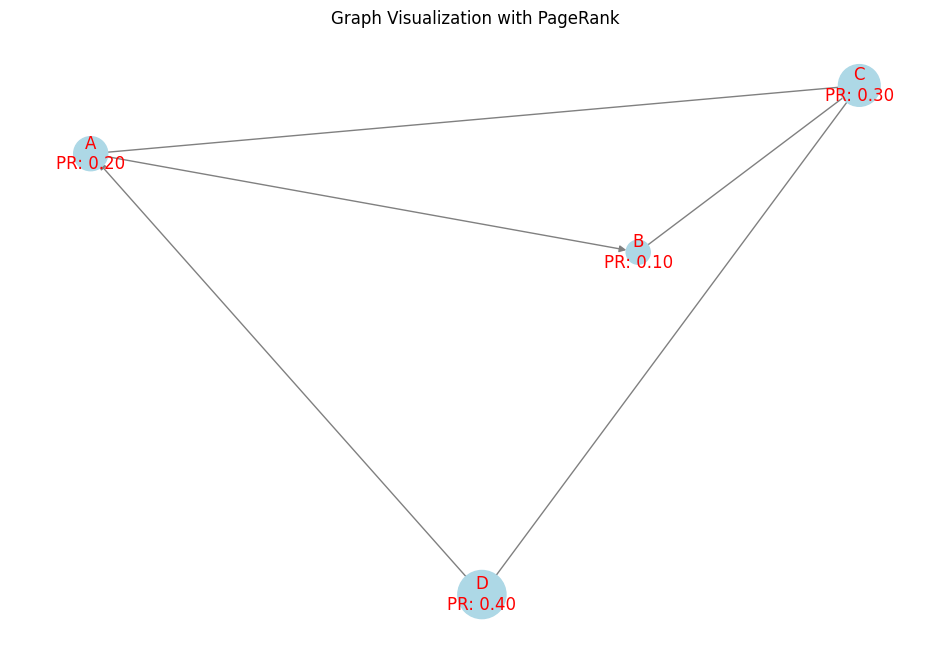

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def visualize_graph_with_pagerank(edges_df, pagerank_df):
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges from the DataFrame
    for index, row in edges_df.iterrows():
        G.add_edge(row['src'], row['dst'])

    # Add PageRank values as node attributes
    pagerank_dict = dict(zip(pagerank_df['id'], pagerank_df['pagerank']))
    nx.set_node_attributes(G, pagerank_dict, 'pagerank')

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  # Positions for all nodes

    # Draw nodes with sizes proportional to PageRank
    node_sizes = [pagerank_dict.get(node, 0) * 3000 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue')

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Draw labels with PageRank
    pagerank_labels = nx.get_node_attributes(G, 'pagerank')
    node_labels = {node: f"{node}\nPR: {pagerank:.2f}" for node, pagerank in pagerank_labels.items()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='red')

    plt.title("Graph Visualization with PageRank")
    plt.axis('off')  # Turn off the axis
    plt.show()


edges_data = {
    'src': ['A', 'A', 'B', 'C', 'D'],
    'dst': ['B', 'C', 'C', 'D', 'A']
}

# Example PageRank data
pagerank_data = {
    'id': ['A', 'B', 'C', 'D'],
    'pagerank': [0.2, 0.1, 0.3, 0.4]
}

# Convert to pandas DataFrame
edges_df = pd.DataFrame(edges_data)
pagerank_df = pd.DataFrame(pagerank_data)

# Visualize the graph
visualize_graph_with_pagerank(edges_df, pagerank_df)
